In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(7395, 20)
(7395, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_RL_swing = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_RL_swing = Y_footsteps_accelerations_absolute[idxs]

## Predict RL foot -> x

In [8]:
X_footsteps_accelerations_absolute_RL_swing[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00, -7.23774556e-04,
        1.63913405e-02, -4.25253900e-03,  2.52678370e-01,  1.34278938e-01,
       -2.77884607e-01,  2.48699126e-01, -1.23663102e-01, -3.13305709e-01,
       -2.69007467e-01,  1.27140112e-01, -3.13660563e-01, -2.69880417e-01,
       -1.35002353e-01, -2.81540030e-01,  0.00000000e+00,  1.00000000e+00])

In [9]:
X_footsteps_accelerations_absolute_RL_swing[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00, -7.23774556e-04,
        1.63913405e-02, -4.25253900e-03,  2.52678370e-01,  1.34278938e-01,
       -2.77884607e-01,  2.48699126e-01, -1.23663102e-01, -3.13305709e-01,
       -2.69007467e-01,  1.27140112e-01, -3.13660563e-01, -2.69880417e-01,
       -1.35002353e-01, -2.81540030e-01,  0.00000000e+00,  1.00000000e+00])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RL_swing[:, 0:1], # current reference velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 3:4], # actual velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 6:8], # FL position
               X_footsteps_accelerations_absolute_RL_swing[:, 9:11], # FR position
               X_footsteps_accelerations_absolute_RL_swing[:, 12:14], # RL position
               X_footsteps_accelerations_absolute_RL_swing[:, 15:17])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RL_swing[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rl_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9909372799539412
RMSE:  0.016534929205449498
The lowest error is:  0.00012658348469490877
The highest error is:  0.045459327995255316
The avg. error is:  0.012444282997953198


In [12]:
model_rl_relative_swinging_x.coef_

array([[ 0.29476012,  0.37255638, -0.19666099, -0.20529423, -1.10887963,
        -0.67182016,  0.59328337,  0.8695958 , -0.6709506 , -0.1866163 ]])

In [13]:
model_rl_relative_swinging_x.intercept_

array([0.11607556])

Text(0, 0.5, 'Predictions')

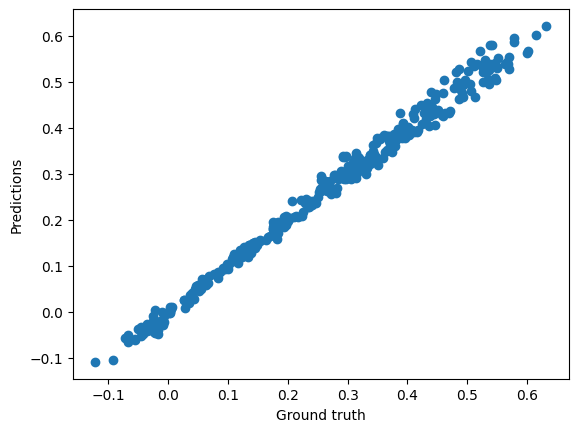

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [16]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RL_swing[:, 0:1], # current reference velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 3:4], # actual velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 6:8], # FL position
               X_footsteps_accelerations_absolute_RL_swing[:, 9:11], # FR position
               X_footsteps_accelerations_absolute_RL_swing[:, 12:14], # RL position
               X_footsteps_accelerations_absolute_RL_swing[:, 15:17])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RL_swing[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rl_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9327590009784665
RMSE:  0.004485407473380803
The lowest error is:  8.305394273291217e-06
The highest error is:  0.012546674040303851
The avg. error is:  0.0034923308712755115


In [17]:
model_rl_relative_swinging_y.coef_

array([[ 0.04987723,  0.00214641,  0.55488705,  0.05641943, -0.10095723,
        -1.14232925,  0.11468043,  0.10034111, -0.71062025,  0.63335682]])

In [18]:
model_rl_relative_swinging_y.intercept_

array([-0.3599297])

Text(0, 0.5, 'Predictions')

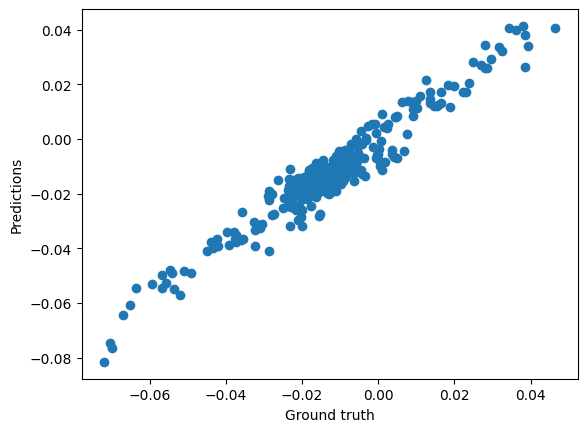

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')